In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [4]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

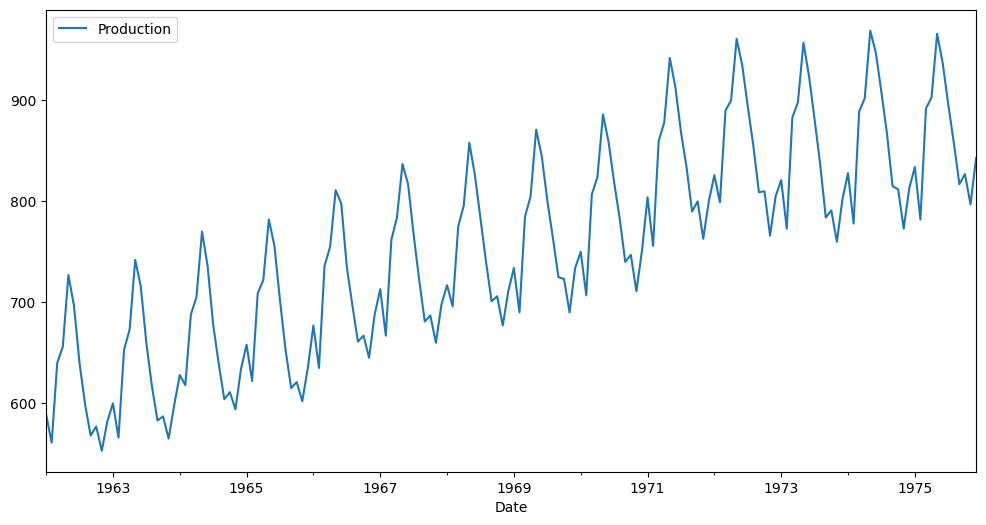

In [5]:
df.plot(figsize=(12,6))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

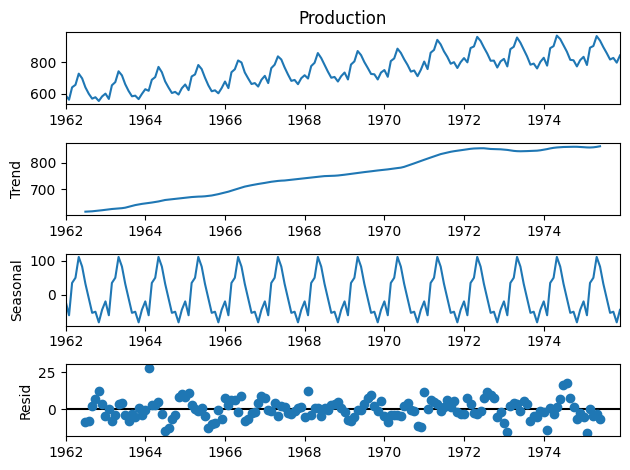

In [7]:
results = seasonal_decompose(df['Production'])
results.plot();

In [8]:
len(df)

168

In [9]:
train = df.iloc[:156]
test = df.iloc[156:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [13]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [14]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

2023-04-11 01:14:30.124523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [18]:
X.shape

(1, 3, 1)

In [19]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2023-04-11 01:14:52.938145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 4ms/step - loss: 0.0486
Epoch 2/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0250
Epoch 3/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0188
Epoch 4/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 5/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0298
Epoch 6/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0135
Epoch 7/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 8/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0061
Epoch 9/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 10/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 11/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 12/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0040
Epoch 13/50
144/144 [====

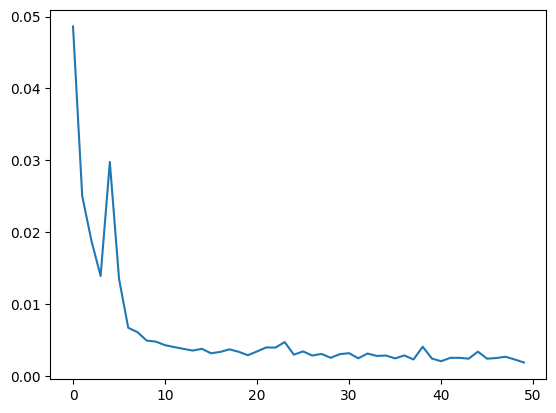

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
last_train_batch = scaled_train[-12:]

In [26]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [27]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 214ms/step


array([[0.58759826]], dtype=float32)

In [28]:
scaled_test[0]

array([0.67548077])

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [30]:
test_predictions

[array([0.58759826], dtype=float32),
 array([0.56345165], dtype=float32),
 array([0.7285846], dtype=float32),
 array([0.7958359], dtype=float32),
 array([0.9058619], dtype=float32),
 array([0.8905338], dtype=float32),
 array([0.8095291], dtype=float32),
 array([0.7030549], dtype=float32),
 array([0.59879154], dtype=float32),
 array([0.5604212], dtype=float32),
 array([0.5141952], dtype=float32),
 array([0.53993195], dtype=float32)]

In [31]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [32]:
true_predictions = scaler.inverse_transform(test_predictions)

In [33]:
test['Predictions'] = true_predictions

/var/folders/rb/g6gdxk7s71v693y9v4phyy_h0000gn/T/ipykernel_20274/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

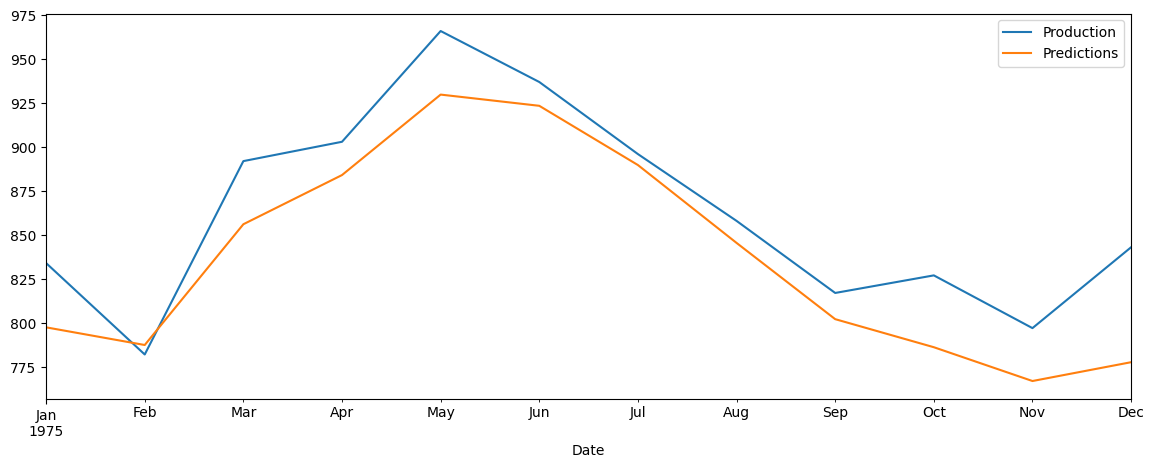

In [34]:
test.plot(figsize=(14,5))

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

31.323178214880418
